# iTunes music library analysis: Preprocessing Data

This is the third post in a series of posts devoted to analysis of iTunes music library using Scikit-Learn tools.   
This notebook covers steps necessary to preprocess data to use it as input for Scikit-learn machine learning algorithms. 

The previous posts cover the following steps:
1. [00_Summary]() — Summary of this analysis, its goals and methods, installation notes.
2. [01_Data_preparation]() — Data gathering and cleaning.
3. [02_Data_visualisation]() — Visualisation and overview of data.

As a result of previous manipulations I have two databases (DBs): 
* training DB contains 88 labeled tracks with one of the three classes: "ballet", "cycling", "yoga";
* test DB contains 444 non-labeled tracks. 

As a shortcut, in this notebook I import module "data_cleaning.py" where I perform steps from the [01_Data_preparation]() notebook. I start with importing the modules required in the following notebook.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np
from sqlitedict import SqliteDict

# import my module from the previous notebook
import data_cleaning as cln

# set seaborn plot defaults
import seaborn as sns; 
sns.set(palette="husl")
sns.set_style("ticks")

# format floating point numbers
# within pandas data structures
pd.set_option('float_format', '{:.2f}'.format)

#### Read in datasets

In [12]:
# train DB
train_db = SqliteDict('./labeled_tracks', autocommit=True)

# create a df with training data
train_df = cln.read_db_in_pandas(train_db)

train_df.sample(3)

,song_title,acousticness,artist,category,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
44,Return To,0.77,#1 Dads,ballet,0.47,0.29,0.05,6,-13.80,0,0.03,127.81,4,0.12
23,Gusts of Wind Blowing in Different Directions,0.96,The Last Dinosaur,yoga,0.36,0.01,0.94,6,-27.53,1,0.04,98.78,1,0.21
77,Undercover Martyn,0.00,Two door cinema club,cycling,0.44,0.86,0.00,11,-4.82,0,0.17,159.82,4,0.57


In [13]:
# test DB
test_db = SqliteDict('./itunes_tracks',
                     autocommit=True)
# create a df with test data
test_df = cln.read_db_in_pandas(test_db)

test_df.sample(3)

,song_title,acousticness,artist,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
360,The Birds and the Bees,0.36,Patrick & Eugene,0.85,0.92,0.00,1,-7.55,1,0.09,123.99,4,0.90
441,the music scene,0.62,blockhead,0.69,0.66,0.36,7,-10.46,1,0.08,100.00,4,0.60
404,We Have Everything,0.00,Young Galaxy,0.60,0.87,0.55,5,-8.06,0,0.04,125.00,4,0.20


In this post, I will go through the following steps:
1. Transform sets to numerical (Numpy) arrays;
2. Standardisation of the features;
3. Dimensionality reduction.

## Transform sets
To work with scikit-learn library, both datasets need to be shaped a bit.
Most machine learning algorithms implemented in scikit-learn expect a numpy array as input. The expected shape of the input is (n_samples, n_features). This applies both to the training and test datasets.
n_samples: the number of samples; each sample is an item to be classified. In our case this would be a track.
n_features: the number of features or distinct traits that can be used to describe each item in a quantitative manner. In our case these are the track attributes. Features like "song_title" and "artist" are not quantitative and are not relevant for the classification task, that's why I exclude these from both inputs.

I transform both dataframes to numerical (Numpy) arrays. I copy the original sets and apply the required changes to copies not to loose any data.

### — Training set —
I start with the training set. "category" column in the training set has to be transformed into numerical format to be processed by scikit-learn algorithms as target data (labels). "Typical" machine learning algorithms handle class labels with "no order implied" - unless a ranking classifier (e.g., SVM-rank) is used. Thus, it is save to use a simple set-item-enumeration to convert the class labels from a string representation into integers.

I use LabelEncoder scikit-learn function, which encodes labels with values between 0 and n_classes-1. 

In [14]:
# transform target classes to numerical labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# list the three categories
categories = list(pd.unique(train_df.category.ravel()))
le.fit(categories)

# list target classes
list(le.classes_)

[u'ballet', u'cycling', u'yoga']

In [15]:
# create an array with target labels
target = le.transform(train_df['category'])
target

array([1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 2, 1,
       2, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 2, 2,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 2])

I set up a matrix so that each track (observation) forms a row, and the track attributes (features) form columns.

In [16]:
# make a copy of the training df
# keep only numerical values
cols = train_df.select_dtypes(exclude=[object]).columns
train_matrix = train_df[cols]

# review the set
train_matrix.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
0,0.66,0.39,0.60,0.00,1,-9.80,1,0.03,190.04,4,0.58
1,0.98,0.09,0.01,0.96,6,-29.25,1,0.04,87.99,4,0.03
2,0.95,0.06,0.07,0.91,8,-24.79,0,0.04,67.25,5,0.03
3,0.82,0.17,0.19,0.80,6,-25.12,1,0.05,127.61,4,0.11
4,0.36,0.40,0.55,0.00,1,-8.60,0,0.03,77.73,4,0.85


In [17]:
# convert to a numerical (Numpy) array
train_data = np.nan_to_num(train_matrix.values)
train_data.shape

(88, 11)

### — Test set —

In [18]:
# make a copy of the test df
# keep only numerical values
cols = test_df.select_dtypes(exclude=[object]).columns
test_matrix = test_df[cols]

# review the set
test_matrix.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,time_signature,valence
0,0.01,0.58,0.86,0.01,4,-7.14,0,0.04,99.01,4,0.54
1,0.39,0.31,0.30,0.85,10,-11.28,0,0.03,142.21,3,0.37
2,0.80,0.80,0.31,0.86,7,-14.80,1,0.05,131.53,4,0.72
3,0.58,0.71,0.51,0.90,5,-10.88,1,0.03,93.03,4,0.44
4,0.10,0.52,0.93,0.00,11,-8.22,0,0.04,103.05,4,0.31


In [19]:
# convert to a numerical (Numpy) array
test_data = np.nan_to_num(test_matrix.values)
test_data.shape

(444, 11)

## Data Standardization
It is necessary to perform standardization of features in both sets. This step is required because when training the models estimators might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. In our case "tempo" attribute varies from 46.22 to 194.90, whereas "loudness" is in range [-35.89, -1.84], and most features are whithin [0, 1] boundaries. The estimator will be unable to learn from other features correctly as expected.  
 
So it is essential to rescale the inputs so that their variability reflects their importance, or at least is not in
inverse relation to their importance. For lack of better prior information, I standardize each input to the same standard deviation. 

I use scikit-learn module StandardScaler() for this purpose. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.

In [81]:
# perform standardization of features
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(train_data)
train_std = std_scale.transform(train_data)

print("Mean after standardization:\nAcousticness={:.2f}, " 
      "Loudness={:.2f}, Mode={:.2f}, Tempo={:.2f}"
      .format(train_std[:,0].mean(), train_std[:,5].mean(),
             train_std[:,6].mean(), train_std[:,8].mean()))

print("\nStandard deviation after standardization:"
      "\nAcousticness={:.2f}, Loudness={:.2f}, " 
      "Mode={:.2f}, Tempo={:.2f}"
      .format(train_std[:,0].std(), train_std[:,5].std(),
             train_std[:,6].std(), train_std[:,8].std()))

Mean after standardization:
Acousticness=-0.00, Loudness=-0.00, Mode=-0.00, Tempo=-0.00

Standard deviation after standardization:
Acousticness=1.00, Loudness=1.00, Mode=1.00, Tempo=1.00


#### Plot the result

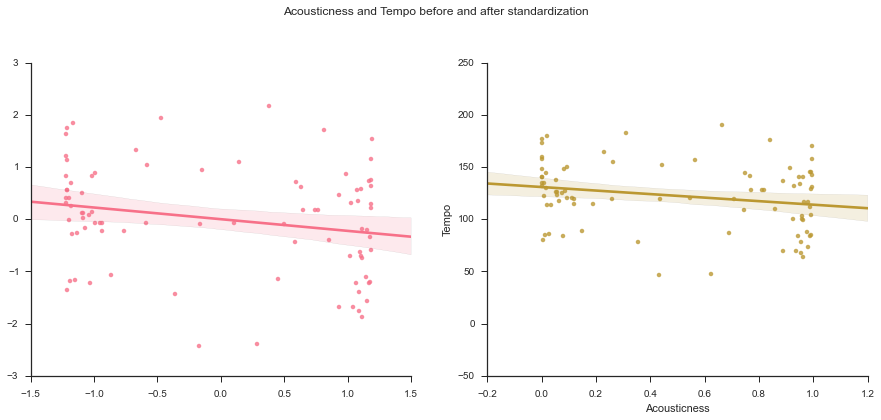

In [103]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, 
                               sharey=False,
                               figsize=(15,6))

# space between the title and the plot
plt.subplots_adjust(top=0.85) 
# add a title
fig.suptitle('Acousticness and Tempo before and after standardization')

# remove the top and right spines from plots
sns.despine()

# make a scatterplot
sns.regplot(x=train_std[:,0], y=train_std[:,8], data=train_std, ax=ax1)
sns.regplot(x=train_data[:,0], y=train_data[:,8], data=train_data, ax=ax2)
plt.xlabel('Acousticness')
plt.ylabel('Tempo')